# Génération de données vraisemblables

Dans ce notebook, on utilise le modèle BM-SEIR pour générer des données vraisemblables. Les fonctions nécessaires à la génération des données sont passées dans un fichier externe, 'utilities.py' pour éviter d'alourdir le notebook. 

In [518]:
% run 'utilities.py'

#### Sauvegarder les données générées de manière satisfaisante (et les seed qui vont avec !)

In [92]:
import pandas as pd

# Importation des données 
data = pd.read_csv("H1N1-London-2009-master/data/data.csv")
data.head()

,date,London__HPA__inc
0,2009-06-01,0.4893
1,2009-06-08,1.4171
2,2009-06-15,3.9675
3,2009-06-22,15.4217
4,2009-06-29,25.9461


In [93]:
import datetime as dt

# Convertir la date au format datetime
dates = data.date.values
data["date"] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
data.head()

,date,London__HPA__inc
0,2009-06-01,0.4893
1,2009-06-08,1.4171
2,2009-06-15,3.9675
3,2009-06-22,15.4217
4,2009-06-29,25.9461


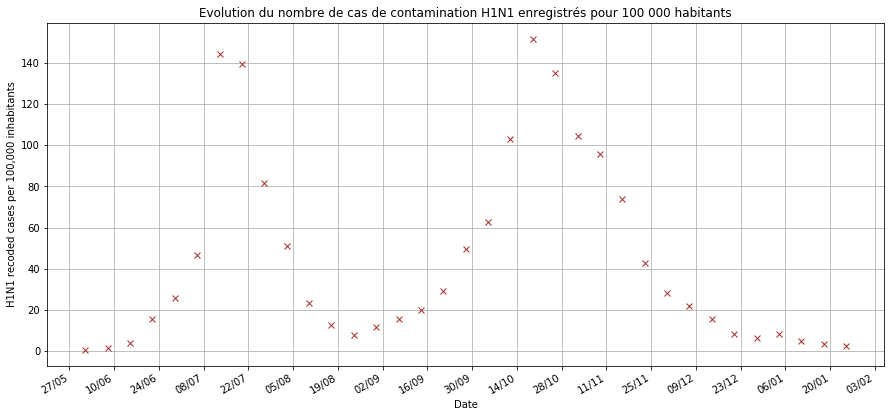

In [128]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot

# Paramètres visuels
kwargs = {'alpha' : 0.99, 'c': 'brown', 'marker' : 'x'}

# Visualisation
fig, ax = plt.subplots(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.plot_date(data.date,data.London__HPA__inc, **kwargs)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("H1N1 recoded cases per 100,000 inhabitants")
plt.title("Evolution du nombre de cas de contamination H1N1 enregistrés pour 100 000 habitants")

plt.show()

In [678]:
import random

# Seed pour la reproducibilité 
# (11 et paramètres suivants : mu, sigma, gamma = 0., 0.6, 3 sigma_x = .25)

np.random.seed(22)

In [679]:
import sdeint
import numpy as np
import math

# Simulation des données

# Paramètres
mu, sigma, gamma = 0., 0.2, 4.

# Variance pour le BM
sigma_x = .5

# Vecteur temporel
t = np.linspace(0, 50, 10000)

# Conditions initiales
S0, E0, I0, R0 = 0.9, 0.0, 0.1, 0.
y0 = np.array([S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

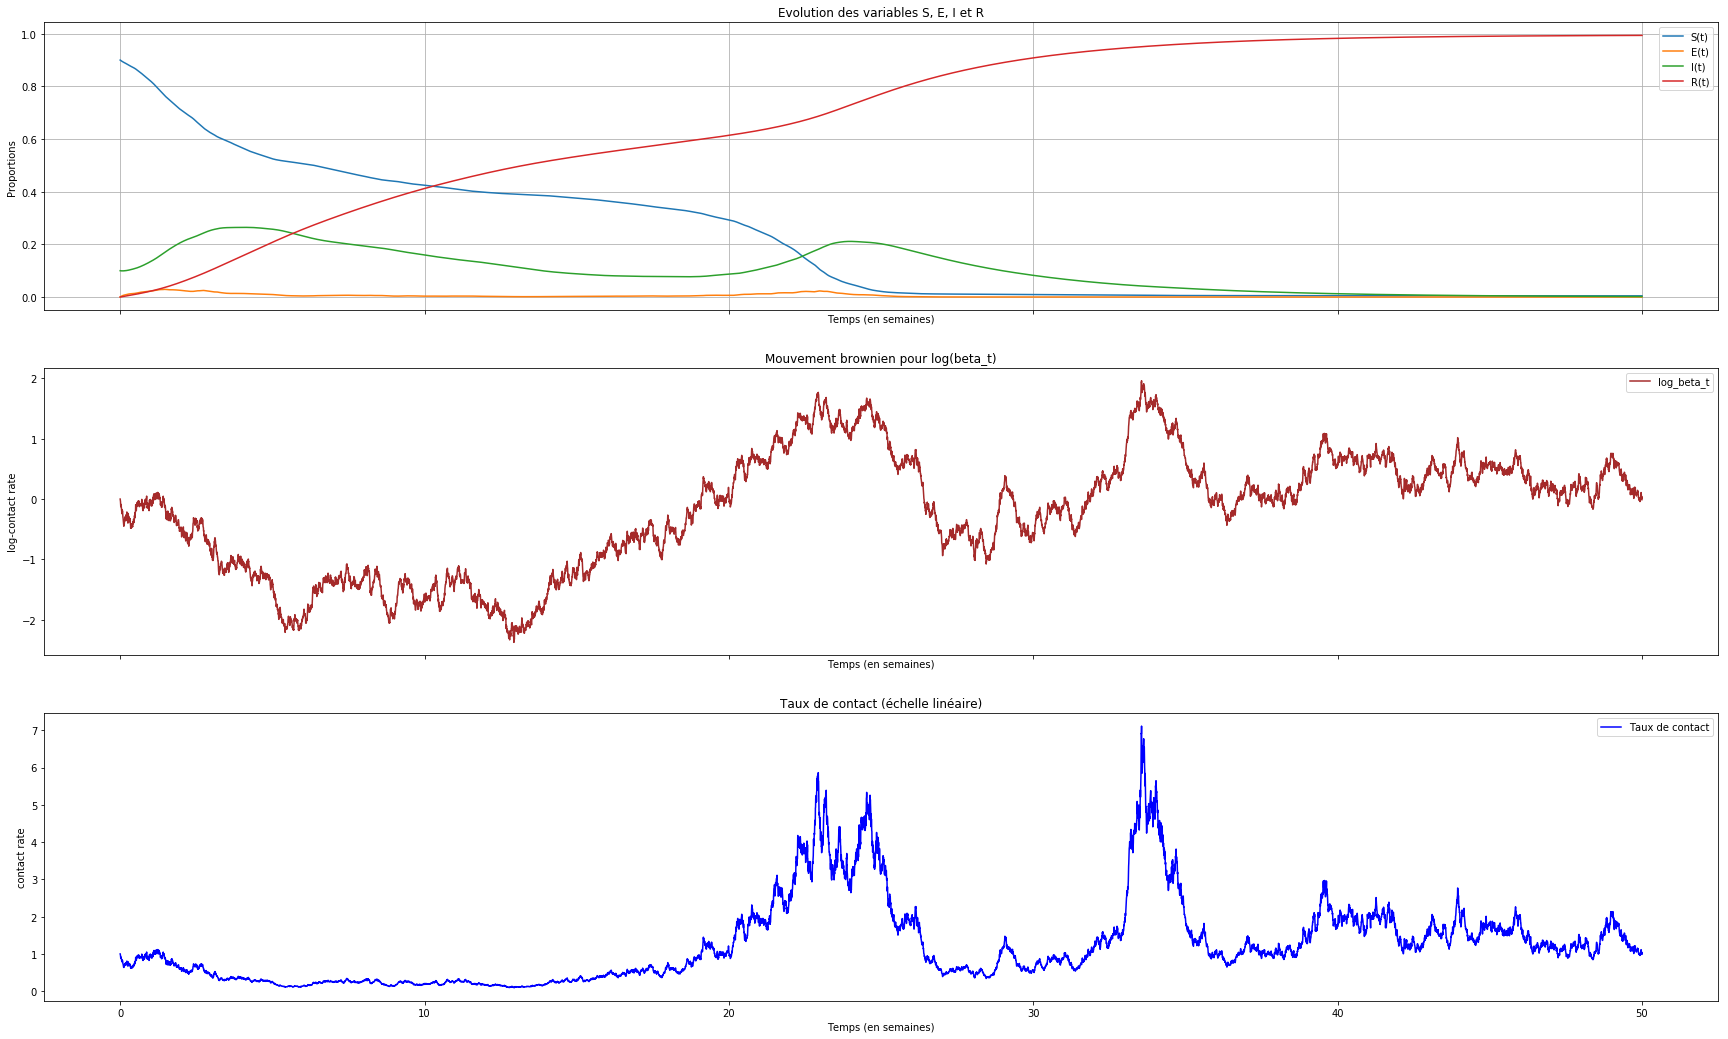

In [680]:
# Affichage de la trajectoire simulée
plot_realisation(result, t, {}, {}, {}, (10,20))

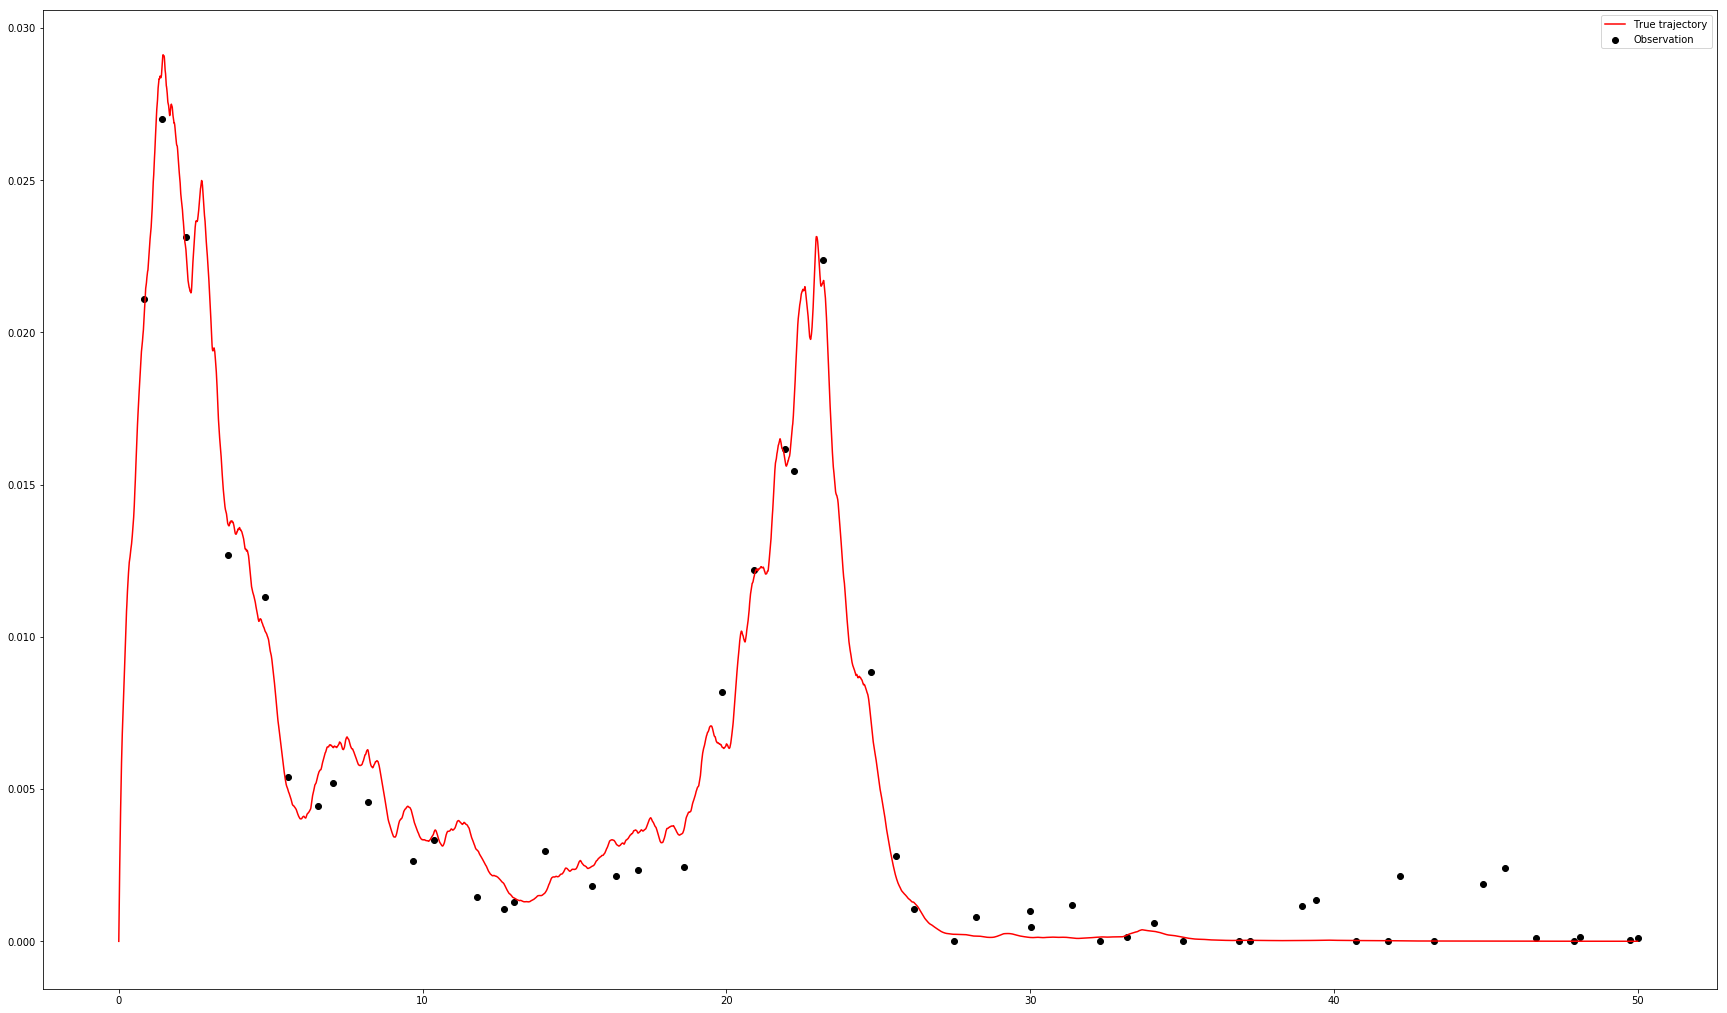

In [689]:
# Observations aléatoires pour E_t
I_t = result[:,1]
vals, indices = generate_noisy_prevalence(I_t, .001, 1, t)

plt.plot(t, I_t, c = "red", label = "True trajectory")
plt.scatter(t[indices], vals, c = 'black', label = "Observation")
plt.legend()

plt.rcParams["figure.figsize"] = (30,18)
plt.show()

In [690]:
# Maintenant qu'on a généré une tendance assez similaire (double pic)
# On les retravaille pour que cela ressemble un peu plus aux données de base

data.London__HPA__inc.describe()

count     35.000000
mean      44.207154
std       46.561858
min        0.489300
25%        8.338100
50%       23.268500
75%       68.248500
max      151.738600
Name: London__HPA__inc, dtype: float64

In [691]:
import statistics as stat

# Changement d'échelle

vals =[ math.exp(i*100)**1.4 - 1 for i in vals]

In [692]:
# Stocker ces valeurs dans une DataFrame
fake_data = pd.DataFrame()
fake_data["date"] = data.date
fake_data["incidence"] = vals[:35] # On retient les 35 premiers points pour matcher avec les vraies données

In [693]:
fake_data.incidence.describe()

count    35.000000
mean      4.300071
std       9.097523
min       0.000000
25%       0.172000
50%       0.478878
75%       3.165263
max      42.915281
Name: incidence, dtype: float64

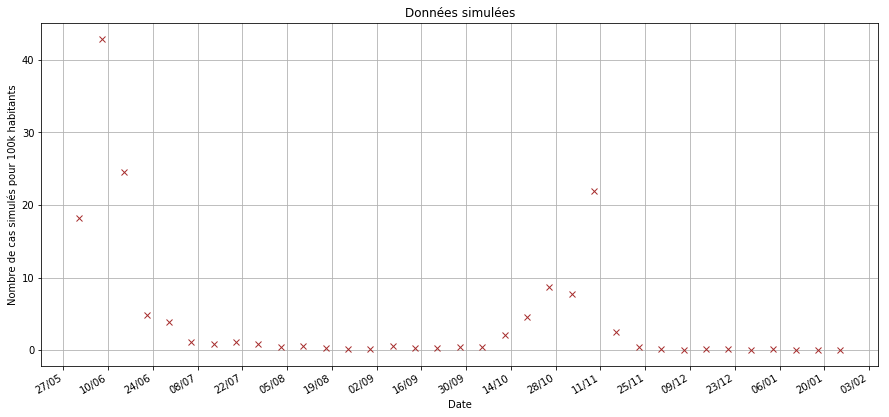

In [694]:
# Plot

# Paramètres visuels
kwargs = {'alpha' : 0.99, 'c': 'brown', 'marker' : 'x'}

# Visualisation
fig, ax = plt.subplots(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.plot_date(fake_data.date,fake_data.incidence, **kwargs)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Nombre de cas simulés pour 100k habitants")
plt.title("Données simulées")

plt.show()



In [695]:
# Exporter le .csv

fake_data.to_csv("generative_data.csv", header = True)